In this tutorial, we will introduce how to load our pretrained models from huggingface model hub and make predictions using trained models. We will then explain the prediction outcomes and showcase some result manipulations.

## Overview

- [Load Pretrained Models from the Hub](#load-pretrained-models-from-the-hub)
- [Make Predictions](#make-predictions)
    - [Prior to Making Predictions](#prior-to-making-predictions)
    - [Individual Predictions and Evaluation](#individual-predictions-and-evaluation)
    - [Batched Predictions and Evaluations](#batched-predictions-and-evaluations)

## Load Pretrained Models from the Hub

As a direct continuation from our [previous tutorial](./Loading%20unicausal%20model.ipynb), we load our pre-trained configs, model, and tokenizer from the HuggingFace model hub. They will come in handy for prediction and save you much time and resources from training the model from scratch.

In [1]:
# install dependencies for later operations
!pip install seqeval

In [2]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2

In [3]:
# import dependencies from HuggingFace transformers library
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
)
from models.classifiers.modeling_bert import BertForUnifiedCRBase

# declare label-to-id mapping and related model parameters
label_to_id = {'B-C': 0, 'B-E': 1, 'I-C': 2, 'I-E': 3, 'O': 4}
label_list = list(label_to_id.keys())
num_labels = len(label_list)
alpha = 1 
cache_dir = None
model_name_or_path = "tanfiona/unicausal" # model path at HuggingFace hub

# initialize useful constructs for prediction
config = AutoConfig.from_pretrained(
    model_name_or_path, num_labels=num_labels
)
# preview configurations
print('### Config ###')
print(config)
model = BertForUnifiedCRBase.from_pretrained(
    model_name_or_path,
    from_tf=bool(".ckpt" in model_name_or_path),
    config=config,
    num_seq_labels=2,
    loss_function='simple',
    alpha=alpha
)
# preview model architecture
print('### Model ###')
print(model)
tokenizer = AutoTokenizer.from_pretrained(
    model_name_or_path,
    cache_dir=cache_dir,
    use_fast=True
)
# preview sentence tokenizer
print('### Tokenizer ###')
print(tokenizer)

### Config ###
BertConfig {
  "_name_or_path": "tanfiona/unicausal",
  "architectures": [
    "BertForUnifiedCRBase"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 29000
}

### Model ###
BertForUnifiedCRBase(
  (bert): BertModel(
    (embeddings)

## Make Predictions

### Prior to Making Predictions

There are three tasks overall: sequence classification, span detection, and pair classification. We will go through examples for each task.


Before getting to the examples, here is some data loading and processing work that is necessary. Feel free to just run the cells without knowing the details. Examples follow immediately and they are more easily understandable.

In [75]:
## Preparation and house-keeping stuff - can just run and skip
from transformers import default_data_collator
from _datasets.unifiedcre import load_cre_dataset, available_datasets
from torch.utils.data import DataLoader

# load example datasets for validation
span_datasets, seq_datasets, stats = load_cre_dataset(dataset_name=['altlex'], \
            do_train_val=True, do_train=False, data_dir='../data')

# hardcode attributes for dataset processing
PADDING_DICT = {
    'input_ids': 0,
    'tokens': '[PAD]',
    'attention_mask': 0,
    'labels': -100,
    'label': -100,
    'ce_tags': -100,
    'ce_tags1': -100,
    'ce_tags2': -100,
    'token_type_ids': 0
    }

padding = "max_length" # defaults to pad to max length, in this case 128.
max_seq_length = 128
text_column_name = "text"
span_label_column_name = "ce_tags"
seq_label_column_name = "label"
span_structure_source = list(span_datasets.keys())[0]
seq_structure_source = list(seq_datasets.keys())[0]
features = span_datasets[span_structure_source].features

# aux function for tokenizing raw sequence texts
def tokenize_and_add_tags(examples):
    tokenized_inputs = tokenizer(
        examples[text_column_name],
        max_length=max_seq_length,
        padding=padding,
        truncation=True,
        is_split_into_words=False
    )
    dummy_span_labels = [] # missing spans / we don't want to train or evaluate on them
    for ids in tokenized_inputs["input_ids"]: # list of list
        sequence_length = len(ids)
        dummy_span_labels.append([PADDING_DICT[span_label_column_name]]*sequence_length)
    
    tokenized_inputs[span_label_column_name] = dummy_span_labels
    tokenized_inputs[f"{span_label_column_name}1"] = dummy_span_labels
    tokenized_inputs[f"{span_label_column_name}2"] = dummy_span_labels
    tokenized_inputs[seq_label_column_name] = examples[seq_label_column_name]

    return tokenized_inputs

# process raw sequence datasets using defined functionality
processed_seq_datasets = seq_datasets.map(
    tokenize_and_add_tags,
    batched=True,
    # remove_columns=seq_datasets[seq_structure_source].column_names,
    desc="Running tokenizer on dataset",
)

# aux function for tokenizing span datasets
def tokenize_and_align_tags(examples):
    tokenized_inputs = tokenizer(
        examples[text_column_name],
        max_length=max_seq_length,
        padding=padding,
        truncation=True,
        # We use this argument because the texts in our dataset are lists of words (with a label for each word).
        is_split_into_words=True,
    )

    tags, tags1, tags2 = [], [], []
    for i, (label,label1,label2) in enumerate(zip(\
        examples[span_label_column_name],
        examples[f"{span_label_column_name}1"],
        examples[f"{span_label_column_name}2"],
        )):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids, label_ids1, label_ids2 = [], [], []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(PADDING_DICT[span_label_column_name])
                label_ids1.append(PADDING_DICT[f"{span_label_column_name}1"])
                label_ids2.append(PADDING_DICT[f"{span_label_column_name}2"])
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label_to_id[label[word_idx]])
                label_ids1.append(label_to_id[label1[word_idx]])
                label_ids2.append(label_to_id[label2[word_idx]])
            # For the other tokens in a word, we set the label to the current label
            else:
                label_ids.append(PADDING_DICT[span_label_column_name])
                label_ids1.append(PADDING_DICT[f"{span_label_column_name}1"])
                label_ids2.append(PADDING_DICT[f"{span_label_column_name}2"])
            previous_word_idx = word_idx
        tags.append(label_ids)
        tags1.append(label_ids1)
        tags2.append(label_ids2)
    
    tokenized_inputs[span_label_column_name] = tags
    tokenized_inputs[f"{span_label_column_name}1"] = tags1
    tokenized_inputs[f"{span_label_column_name}2"] = tags2
    tokenized_inputs[seq_label_column_name] = examples[seq_label_column_name]

    return tokenized_inputs


# process raw span datasets using defined functionality
processed_span_datasets = span_datasets.map(
    tokenize_and_align_tags,
    batched=True,
    remove_columns=span_datasets[span_structure_source].column_names,
    desc="Running tokenizer on dataset",
)

  0%|          | 0/1 [00:00<?, ?it/s]

Running tokenizer on dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Running tokenizer on dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Running tokenizer on dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

### Individual Predictions and Evaluation

Next we will show some individual examples for each of the three tasks, before getting to batched predictions whose results are used to calculate evaluation metrics, such as accuracy or f1 score. 

In [ ]:
# For sequence classification
print('##### Sequence Classification Individual Example #####')
example_texts = processed_seq_datasets['seq_validation']['text'][:16]
true_labels = processed_seq_datasets['seq_validation']['label'][:16]
data_collator = default_data_collator
eval_pspan_dataloader = DataLoader(
    processed_seq_datasets['seq_validation'], 
    shuffle=False, collate_fn=data_collator, 
    batch_size=16
)
for (_, batch) in enumerate(eval_pspan_dataloader):
    batch['label'] = batch['labels'].clone()
    del batch['labels']
    predictions = model(**batch)
    break

for i in range(16):
    print(f'Input text #{i+1}:',example_texts[i])
    print('\t [ predicted outcome:',predictions.seq_logits[i].argmax(dim=-1).tolist(),'vs actual outcome:',true_labels[i],']')

Since it is a classification problem, we may compute metrics such as accuracy, precision, recall, and f1 scores to evaluate model performance, as shown below.

/home/jiatong/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


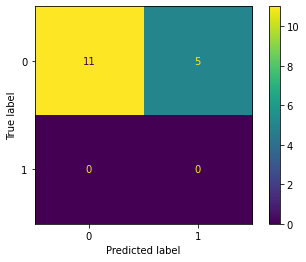

{'accuracy': 0.6875, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}

In [130]:
# Compute metrics
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def compute_metrics(pred):
    labels = true_labels
    preds = predictions.seq_logits.argmax(dim=-1).tolist() 
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds)
    recall = recall_score(labels, preds)
    f1 = f1_score(labels, preds)
    
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

    plt.show()

    return {
      'accuracy': acc,
      'precision': prec,
      'recall': recall,
      'f1': f1,
    }

compute_metrics(predictions)

By definition:
```
    accuracy = (TP + TN) / N
    precision = TP / (TP + FP)
    recall = TP / (TP + TN)
    f1 = 2*precision*recall / (precision + recall)
```
where `TP` is True Positive, `FP` is False Positive, `TN` is True Negative, `FN` is False Negative, and `N` is `(TP+FP+TN+FN)`.
All metrics, including accuracy, precisiomn, recall, and f1, follow 'the higher, the better' rule. f1 score is the harmonic mean of precision and recall score, which balances Type I and Type II errors simultaneously, namely, it punishs cases where a sentence actually contains causal relation but classified as non-causal, as well as the cases where a sentence is not causal but misclassified as causal.   

In [103]:
# For pair classification
print('##### Pair Classification Individual Examples #####')
example_texts = processed_seq_datasets['pair_validation']['text'][:8]
true_labels = processed_seq_datasets['pair_validation']['label'][:8]
data_collator = default_data_collator
eval_pspan_dataloader = DataLoader(
    processed_seq_datasets['pair_validation'], 
    shuffle=False, collate_fn=data_collator, 
    batch_size=8
)
for (_, batch) in enumerate(eval_pspan_dataloader):
    batch['label'] = batch['labels'].clone()
    del batch['labels']
    predictions = model(**batch)
    break

for i in range(8):
    print(f'Input text #{i+1}:',example_texts[i])
    print('\t # predicted outcome:',predictions.seq_logits[i].argmax(dim=-1).tolist(),'vs actual outcome:',true_labels[i])

##### Pair Classification Individual Examples #####
Input text #1: <ARG1>The Bhopal disaster , also referred to</ARG1> as <ARG0>the Bhopal gas tragedy , was a gas leak incident in India , considered the world 's worst industrial disaster .</ARG0>
	 # predicted outcome: 0 vs actual outcome: 0
Input text #2: <ARG1>In addition , several vent gas scrubbers had been out of service as well</ARG1> as <ARG0>the steam boiler , intended to clean the pipes .</ARG0>
	 # predicted outcome: 0 vs actual outcome: 0
Input text #3: <ARG1>Union Carbide organized a team of international medical experts ,</ARG1> as <ARG0>well as supplies and equipment , to work with the local Bhopal medical community , and the UCC technical team began assessing the cause of the gas leak .</ARG0>
	 # predicted outcome: 0 vs actual outcome: 0
Input text #4: <ARG1>Following an appeal of this decision , the U.S. Court of Appeals affirmed the transfer , judging , in January 1987 , that UCIL was a `` separate entity , owned , ma

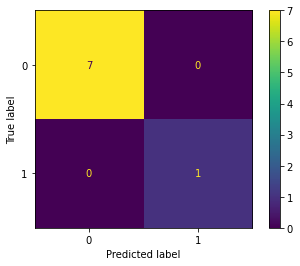

{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}

In [104]:
# Evaluate pair classification outcomes
compute_metrics(predictions)

In [111]:
# For span detection
print('##### Span Detection Individual Examples #####')
example_tags1 = processed_span_datasets['span_validation']['ce_tags'][:8]
example_tags2 = processed_span_datasets['span_validation']['ce_tags1'][:8]
example_tags3 = processed_span_datasets['span_validation']['ce_tags2'][:8]
true_labels = processed_span_datasets['span_validation']['label'][:8]
data_collator = default_data_collator
eval_pspan_dataloader = DataLoader(
    processed_span_datasets['span_validation'], 
    shuffle=False, collate_fn=data_collator, 
    batch_size=8
)
for (_, batch) in enumerate(eval_pspan_dataloader):
    batch['label'] = batch['labels'].clone()
    del batch['labels']
    predictions = model(**batch)
    break

print('Only first ten predicted tokens are printed.')

for i in range(8):
    print(f'Input example #{i+1}')
    print('\t predicted tag1:',predictions.tok_logits[i].argmax(dim=-1).tolist()[:10],'vs actual tag1:',example_tags1[i][:10])
    print('\t predicted tag2:',predictions.tok_logits1[i].argmax(dim=-1).tolist()[:10],'vs actual tag2:',example_tags2[i][:10])
    print('\t predicted tag3:',predictions.tok_logits2[i].argmax(dim=-1).tolist()[:10],'vs actual tag3:',example_tags3[i][:10])

##### Span Detection Individual Examples #####
Only first ten predicted tokens are printed.
Input example #1
	 predicted tag1: [3, 0, 2, 2, 2, 2, 2, 2, 2, 2] vs actual tag1: [-100, 0, 2, -100, -100, -100, 2, 2, 2, 2]
	 predicted tag2: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4] vs actual tag2: [-100, 4, 4, -100, -100, -100, 4, 4, 4, 4]
	 predicted tag3: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4] vs actual tag3: [-100, 4, 4, -100, -100, -100, 4, 4, 4, 4]
Input example #2
	 predicted tag1: [3, 4, 4, 4, 4, 4, 4, 0, 2, 2] vs actual tag1: [-100, 0, 2, 2, 2, 4, 4, 1, 3, 3]
	 predicted tag2: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4] vs actual tag2: [-100, 4, 4, 4, 4, 4, 4, 4, 4, 4]
	 predicted tag3: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4] vs actual tag3: [-100, 4, 4, 4, 4, 4, 4, 4, 4, 4]
Input example #3
	 predicted tag1: [3, 4, 4, 4, 2, 1, 3, 3, 3, 3] vs actual tag1: [-100, 0, 2, 4, 1, 3, 3, 3, 3, 3]
	 predicted tag2: [4, 4, 4, 4, 4, 4, 4, 4, 4, 4] vs actual tag2: [-100, 4, 4, 4, 4, 4, 4, 4, 4, 4]
	 predicted tag3: [4, 4, 4, 4, 4, 4, 4

In [ ]:
# Compute metrics for span detection task
def compute_metrics(pred):
    labels = example_tags1 + example_tags2 + example_tags3
    preds = predictions.tok_logits.argmax(dim=-1).tolist() + predictions.tok_logits1.argmax(dim=-1).tolist() + predictions.tok_logits2.argmax(dim=-1).tolist()

    cancat_labels = []
    cancat_preds = []
    for label in labels:
      cancat_labels.extend(label[:10])
    for pred in preds:
      cancat_preds.extend(pred[:10])
    acc = accuracy_score(cancat_labels, cancat_preds, )
    prec = precision_score(cancat_labels, cancat_preds, average='weighted')
    recall = recall_score(cancat_labels, cancat_preds, average='weighted')
    f1 = f1_score(cancat_labels, cancat_preds, average='weighted')
    
    cm = confusion_matrix(cancat_labels, cancat_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

    plt.show()

    return {
      'accuracy': acc,
      'precision': prec,
      'recall': recall,
      'f1': f1,
    }

compute_metrics(predictions)

### Batched Predictions
Below is the actual batched prediction that is used during training. Metrics are computed and printed in the second last cell.

In [82]:
## Make pytorch dataloader objects for model prediction
# use default data collator as padding is already done at max length
data_collator = default_data_collator

# define dataloaders for prediction
eval_dataset = processed_span_datasets['span_validation']

# for span detection
eval_pspan_dataloader = DataLoader(
    eval_dataset, 
    shuffle=False, collate_fn=data_collator, 
    batch_size=8
    )
eval_pspan_corpus_col = span_datasets["span_validation"]["corpus"]
eval_pspan_unique_corpus = list(set(eval_pspan_corpus_col))

# for sequence classification
eval_aseq_dataloader = DataLoader(
    processed_seq_datasets['seq_validation'], 
    shuffle=False, collate_fn=data_collator, 
    batch_size=8
)
eval_aseq_corpus_col = seq_datasets["seq_validation"]["corpus"]
eval_aseq_unique_corpus = list(set(eval_aseq_corpus_col+eval_pspan_unique_corpus))

# for pair classification
eval_apair_dataloader = DataLoader(
    processed_seq_datasets['pair_validation'], 
    shuffle=False, collate_fn=data_collator, 
    batch_size=8
)
eval_apair_corpus_col = seq_datasets["pair_validation"]["corpus"]
eval_apair_unique_corpus = list(set(eval_apair_corpus_col))

In [83]:
# Prediction results saved here
import torch

all_preds, all_refs = [], []
all_seq_preds, all_seq_refs = [], []
all_pair_preds, all_pair_refs = [], []
device = torch.device('cpu')

def get_labels(predictions, references, ignore_ids=-100, remove_if_no_ce=True):
    # Transform predictions and references tensors to numpy arrays
    if device.type == "cpu":
        y_pred = predictions.detach().clone().numpy()
        y_true = references.detach().clone().numpy()
    else:
        y_pred = predictions.detach().cpu().clone().numpy()
        y_true = references.detach().cpu().clone().numpy()

    # Remove ignored index (special tokens)
    # Remove if all are 'O' (dummy examples)
    true_predictions, true_labels = [], []
    for pred, gold_label in zip(y_pred, y_true):
        true_p, true_l = [], []
        for (p, l) in zip(pred, gold_label):
            if l != ignore_ids:
                true_p.append(label_list[p])
                true_l.append(label_list[l])
        if len(set(true_l))==1 and true_l[0]=='O' and remove_if_no_ce: # all dummy values
            # drop these examples, append empties for alignment to index
            true_predictions.append([])
            true_labels.append([])
        else:
            true_predictions.append(true_p)
            true_labels.append(true_l)

    return true_predictions, true_labels

def format(predictions, labels, remove_if_no_ce=True):
    return get_labels(predictions, labels, PADDING_DICT[span_label_column_name], remove_if_no_ce)

In [88]:
# sequence classification
from tqdm import tqdm
from datasets import load_metric
import torch

metric = {d:load_metric('seqeval') for d in eval_pspan_unique_corpus+['all']}
seq_metric = {d:load_metric('../utils/seq_metrics.py') for d in eval_aseq_unique_corpus+['all']}
pair_metric = {d:load_metric('../utils/seq_metrics.py') for d in eval_apair_unique_corpus+['all']} 

print("***** Running prediction *****")
print(f"  Num seq examples = {len(eval_aseq_corpus_col)}")

model.eval()

for step, batch in enumerate(tqdm(eval_aseq_dataloader)):
    batch['label'] = batch['labels'].clone()
    del batch['labels']
    with torch.no_grad():
        outputs = model(**batch)
        
    # Get Seq Predictions & References
    seq_preds = outputs.seq_logits.argmax(dim=-1).detach().cpu().clone().tolist()
    seq_refs = batch[seq_label_column_name].detach().cpu().clone().tolist()

    # Add to metrics
    seq_metric['all'].add_batch(
        predictions=seq_preds,
        references=seq_refs
    )

    # Add to metrics by dataset name
    corps = eval_aseq_corpus_col[step*8:(step+1)*8] # batch_size=8
    for i,d in enumerate(corps):
        seq_metric[d].add(
            prediction=seq_preds[i],
            reference=seq_refs[i],
        )
    
    # Store predictions
    all_seq_preds.extend(seq_preds)
    all_seq_refs.extend(seq_refs)

***** Running prediction *****
  Num seq examples = 286


100%|██████████| 36/36 [00:21<00:00,  1.66it/s]


For span detection tasks:

In [85]:
print("***** Running prediction *****")
print(f"  Num span examples = {len(eval_pspan_corpus_col)}")

model.eval()

for step, batch in enumerate(tqdm(eval_pspan_dataloader)):
    batch['label'] = batch['labels'].clone()
    del batch['labels']
    with torch.no_grad():
        outputs = model(**batch)

    # Get Span Predictions & References
    preds, refs = format(
        predictions=outputs.tok_logits.argmax(dim=-1), 
        labels=batch[span_label_column_name],
        remove_if_no_ce=False
        )
    preds1, refs1 = format(
        predictions=outputs.tok_logits1.argmax(dim=-1), 
        labels=batch[f"{span_label_column_name}1"],
        remove_if_no_ce=False
        )
    preds2, refs2 = format(
        predictions=outputs.tok_logits2.argmax(dim=-1), 
        labels=batch[f"{span_label_column_name}2"],
        remove_if_no_ce=False
        )
    
    # Add to metrics
    metric['all'].add_batch(
        predictions=preds,
        references=refs 
    ) # predictions and preferences are expected to be a nested list of labels, not label_ids
    metric['all'].add_batch(
        predictions=preds1,
        references=refs1 
    )
    metric['all'].add_batch(
        predictions=preds2,
        references=refs2 
    )
    # Add to metrics by dataset name
    corps = eval_pspan_corpus_col[step*8:(step+1)*8] # batch_size = 8
    for i,d in enumerate(corps):
        metric[d].add(
            prediction=preds[i],
            reference=refs[i],
        )
        metric[d].add(
            prediction=preds1[i],
            reference=refs1[i],
        )
        metric[d].add(
            prediction=preds2[i],
            reference=refs2[i],
        )

    # Store predictions
    all_preds.extend(preds)
    all_refs.extend(refs)
    all_preds.extend(preds1)
    all_refs.extend(refs1)
    all_preds.extend(preds2)
    all_refs.extend(refs2)

***** Running prediction *****
  Num span examples = 115


100%|██████████| 15/15 [00:08<00:00,  1.69it/s]


For pair classification:

In [89]:
print("***** Running prediction *****")
print(f"  Num pair examples = {len(eval_apair_corpus_col)}")

model.eval()

for step, batch in enumerate(tqdm(eval_apair_dataloader)):
    batch['label'] = batch['labels'].clone()
    del batch['labels']
    with torch.no_grad():
        outputs = model(**batch)
    # Get Seq Predictions & References
    seq_preds = outputs.seq_logits.argmax(dim=-1).detach().cpu().clone().tolist()
    seq_refs = batch[seq_label_column_name].detach().cpu().clone().tolist()

    # Add to metrics
    pair_metric['all'].add_batch(
        predictions=seq_preds,
        references=seq_refs
    )

    # Add to metrics by dataset name
    corps = eval_apair_corpus_col[step*8:(step+1)*8] # batch-size=8
    for i,d in enumerate(corps):
        pair_metric[d].add(
            prediction=seq_preds[i],
            reference=seq_refs[i],
        )
    
    # Store predictions
    all_pair_preds.extend(seq_preds)
    all_pair_refs.extend(seq_refs)

***** Running prediction *****
  Num pair examples = 416


100%|██████████| 52/52 [00:28<00:00,  1.83it/s]


### Batched Evaluations

In [92]:
# Evaluate above predictions
return_entity_level_metrics = False
def compute_metrics(d='all'):
    try:
        results = metric[d].compute()
        if return_entity_level_metrics:
            # Unpack nested dictionaries
            final_results = {}
            for key, value in results.items():
                if isinstance(value, dict):
                    for n, v in value.items():
                        final_results[f"{key}_{n}"] = v
                else:
                    final_results[key] = value
            return final_results
        else:
            return {
                "precision": results["overall_precision"],
                "recall": results["overall_recall"],
                "f1": results["overall_f1"],
                "accuracy": results["overall_accuracy"],
            }
    except:
        # No C-E true labels available
        return {
                "precision": 0,
                "recall": 0,
                "f1": 0,
                "accuracy": 0,
            }

def pretty_print(metrics: dict):
    for (k,v) in metrics.items():
        print('\t',"{}: {:.3f}".format(k, v if not isinstance(v, tuple) else v[0]))

for d in eval_pspan_unique_corpus:
    span_eval_metric = compute_metrics(d)
    print(f"span predictions for '{d}' :")
    pretty_print(span_eval_metric)
for d in list(set(eval_pspan_unique_corpus+eval_aseq_unique_corpus)):
    seq_eval_metric = seq_metric[d].compute()
    print(f"seq predictions for '{d}' :")
    pretty_print(seq_eval_metric)
for d in eval_apair_unique_corpus:
    pair_eval_metric = pair_metric[d].compute()
    print(f"pair predictions for '{d}' :")
    pretty_print(pair_eval_metric)

span predictions for 'altlex' :
	 precision: 0.000
	 recall: 0.000
	 f1: 0.000
	 accuracy: 0.000
seq predictions for 'altlex' :
	 n: 286.000
	 accuracy: 0.822
	 matthews_correlation: 0.000
	 macro_precision: 0.500
	 macro_recall: 0.411
	 macro_f1: 0.451
	 weighted_precision: 1.000
	 weighted_recall: 0.822
	 weighted_f1: 0.902
	 binary_precision: 0.000
	 binary_recall: 0.000
	 binary_f1: 0.000
pair predictions for 'altlex' :
	 n: 416.000
	 accuracy: 0.882
	 matthews_correlation: 0.715
	 macro_precision: 0.875
	 macro_recall: 0.840
	 macro_f1: 0.855
	 weighted_precision: 0.881
	 weighted_recall: 0.882
	 weighted_f1: 0.879
	 binary_precision: 0.861
	 binary_recall: 0.732
	 binary_f1: 0.791


/home/jiatong/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jiatong/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jiatong/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


As explained in the first [loading CRE dataset notebook](./Loading%20CRE%20datasets.ipynb), all three tasks are ultimately treated as classifications. Thus, we may use accuracy, precision, recall, and f1 scores to evaluate model performances. They follow their traditional definitions and can be easily looked up online. For explanations of weighted, macro, and micro scores, you may find this [source](https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f#:~:text=The%20weighted%2Daveraged%20F1%20score,the%20class%20in%20the%20dataset.) useful.